**IFTS** TECNICO DEL DISEGNO E PROGETTAZIONE INDUSTRIALE SPECIALIZZATO IN SMART MANUFACTURING (2019)  
**INDUSTRIA 4.0 - Tecnologie Informatiche di Riferimento**

# Machine Learning

## Esercitazione 1: Regressione

Gianluca Moro, **Roberto Pasolini**  
DISI - Dipartimento di Informatica - Scienza e Ingegneria  
Università di Bologna  
nome.cognome@unibo.it

## Introduzione all'ambiente di lavoro

Questo è un documento Jupyter. Al suo interno trovate delle celle contenenti codice Python che potete eseguire, il risultato verrà riportato sotto alla cella stessa. Potete aggiungere e modificare le celle liberamente per svolgere gli esercizi proposti e testare delle variazioni rispetto al codice fornito.

Questo è un esempio di cella di codice:

In [1]:
20 + 20 + 2

42

Cliccate su di essa e premete **Maiusc + Invio** (oppure cliccate sul pulsante col simbolo "Play") per eseguirla: il risultato dell'espressione comparirà sotto di essa. Potete modificare il codice e rieseguire la cella quante volte volete.

Per inserire una nuova cella di codice sotto a quella selezionata, cliccate sul pulsante "+" in alto (oppure premete **B** mentre non state immettendo testo nella cella)

## Esempio 1: predizione del consumo di elettricità

Iniziamo col problema della stima del picco giornaliero di consumo di elettricità in una zona a partire dalla temperatura, di cui si suppone avere una predizione accurata il giorno prima. I passaggi principali che vedremo saranno:

1. caricamento del set di dati
2. selezione dei dati di interesse
3. costruzione di un modello di regressione
4. valutazione del modello

## Caricamento dei dati

Per l'esercitazione utilizziamo dati disponibili pubblicamente sul Web, nello specifico:
- i dati sui consumi di corrente nell'area di Pittsburgh (USA) rilasciati dalla compagnia elettrica: https://dataminer2.pjm.com/feed/hrl_load_metered/definition
- i dati sulle temperature medie giornaliere nella stessa area: https://shawxiaozhang.github.io/wefacts/

Abbiamo raccolto questi dati in un unico file CSV (_Comma Separated Values_), un formato standard di scambio dati. Ogni riga del file contiene una data, la temperatura media alla data stessa e il picco di consumo registrato.

Per caricare i dati usiamo **pandas**, la libreria Python più usata per rappresentare e processare dati in forma tabulare. Iniziamo quindi caricando questa libreria.

In [2]:
import pandas as pd

`pd` è il nome breve usato convenzionalmente per riferirsi a pandas.

Il file CSV con i dati è disponibile all'URL `https://git.io/vpaM1`. Tramite la funzione `read_csv` di pandas possiamo caricare il file direttamente in memoria senza scaricarlo su disco. Nella funzione specifichiamo l'URL del file usiamo l'opzione `parse_dates` per specificare che i valori della colonna `date` sono da interpretare come date.

In [3]:
data = pd.read_csv("https://git.io/vpaM1", parse_dates=["date"])

pandas fornisce anche funzioni per caricare dati da file Excel, database SQL e altre fonti varie.

`data` è il nome assegnato alla tabella che useremo per riferirci ad essa. Possiamo ad esempio consultarne l'attributo `shape` che ci indica il numero di righe e di colonne.

In [4]:
data.shape

(1096, 3)

Con la funzione `head` possiamo invece estrarre le prime N righe contenute nella tabella e visualizzarle.

In [5]:
data.head(5)

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4
3,2015-01-04,1.628577,15.6
4,2015-01-05,2.045394,0.0


La tabella presenta tre colonne:
- `date`: data
- `demand`: picco di consumo (in GW) registrato in quella data
- `temp`: temperatura media (in °C) registrata in quella data

## Visualizzazione dei dati

Una volta compresa la struttura della tabella, è utile esplorare i dati contenuti al suo interno: un modo per farlo è generare dei grafici che mostrino la distribuzione dei valori nelle varie colonne.

pandas fornisce funzioni per generare facilmente grafici tramite **matplotlib**, la libreria Python usata più comunemente per questo scopo.

Prima di procedere, eseguiamo il seguente comando per assicurarci che i grafici generati da matplotlib siano integrati direttamente nel documento Jupyter.

In [6]:
%matplotlib inline

Per avere una prima verifica "visiva" della correlazione tra temperatura e consumi possiamo generare un _grafico a dispersione_ (_scatter plot_): per ogni giorno viene visualizzato un punto su un piano la cui coordinata X indica una variabile (la temperatura) e la cui coordinata Y indica l'altra (il consumo).

pandas fornisce una funzione per generare facilmente un grafico a dispersione, specificando i nomi delle colonne da utilizzare come valori per le X e per le Y.

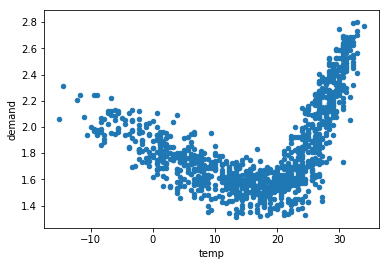

In [7]:
data.plot.scatter("temp", "demand")

Possiamo anche personalizzare il grafico: ad es. cambiamo colore e dimensione dei punti, mostriamo una griglia, aggiungiamo un titolo e cambiamo le etichette degli assi.

[Text(0, 0.5, 'Picco consumo (GW)'),
 Text(0.5, 0, 'Temperatura (°C)'),
 Text(0.5, 1.0, 'Correlazione tra consumi elettrici e temperatura')]

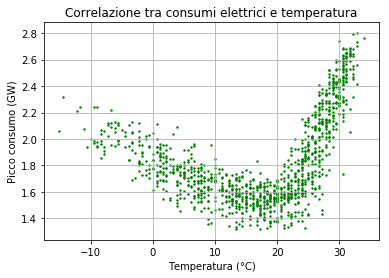

In [8]:
data.plot.scatter("temp", "demand", c="green", s=2, grid=True).set(
    title="Correlazione tra consumi elettrici e temperatura",
    xlabel="Temperatura (°C)",
    ylabel="Picco consumo (GW)"
)

## Selezione dei dati

Un'operazione fondamentale che ci consente di fare pandas è di selezionare un sottoinsieme di righe dalla tabella secondo un criterio specifico.

Ad esempio, per limitare l'analisi ai mesi caldi, selezioniamo solamente le righe relative ai mesi di giugno, luglio e agosto.

Per prima cosa definiamo l'insieme di righe da selezionare tramite la seguente istruzione:

In [9]:
summer_days = data["date"].dt.month.between(6, 8)

- `data["date"]` seleziona dalla tabella la sola colonna delle date
- `.dt.month` estrae a sua volta solamente il mese di ogni data, in forma di numero da 1 (gennaio) a 12 (dicembre)
- `.between(6, 8)` esprime la condizione che il valore sia compreso tra 6 (giugno) e 8 (agosto)

`summer_days` contiene una serie di valori vero/falso ("booleani") che indicano quali righe soddisfano la condizione e quali no: con la seguente istruzione selezioniamo dalla tabella `data` solamente le righe a cui corrisponde "vero":

In [10]:
data_summer = data.loc[summer_days]

Abbiamo quindi ora una tabella `data_summer` contenente solamente le righe di `data` relative ai mesi estivi: possiamo visualizzarne le prime righe...

In [11]:
data_summer.head(5)

,date,demand,temp
151,2015-06-01,1.640036,15.6
152,2015-06-02,1.663211,17.2
153,2015-06-03,1.728381,21.7
154,2015-06-04,1.921615,25.0
155,2015-06-05,2.153111,27.8


...e generarne il grafico a dispersione simile a quello sopra.

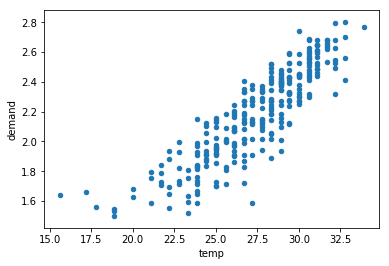

In [12]:
data_summer.plot.scatter("temp", "demand")

Da questo grafico vediamo che effettivamente ai giorni più caldi (punti più a destra) corrisponde un maggiore consumo di corrente (in alto).

## Creare un modello di regressione

Vediamo ora come estrarre da questi dati un modello di regressione che fornisca una stima dei consumi dalla temperatura.

Dal grafico sopra si nota che la correlazione tra la temperatura e il consumo di corrente è pressoché _lineare_: se la temperatura aumenta di 1 °C, i consumi crescono di una quantità fissa indipendentemente dalla temperatura specifica.

Per questo utilizziamo la _regressione lineare_, un modello basilare che funziona assumendo una correlazione lineare tra la variabile indipendente (la temperatura) e quella dipendente (il consumo). In pratica, la regressione lineare individua la retta che approssima nel modo migliore possibile la disposizione dei punti nel grafico a dispersione.

Utilizzeremo **scikit-learn**, una libreria Python che fornisce una vasta varietà di algoritmi di Machine Learning.

Per iniziare carichiamo dalla libreria la classe `LinearRegression` che implementa la regressione lineare.

In [13]:
from sklearn.linear_model import LinearRegression

Creiamo quindi un oggetto che rappresenta il nostro modello specifico. Dalla stessa classe è possibile creare molteplici modelli.

In [14]:
model = LinearRegression()

Per essere utilizzato, il modello va _addestrato_ con i dati a disposizione. Per farlo usiamo la funzione `fit`, passando sia i valori della variabile indipendente che quelli della variabile dipendente, dati rispettivamente dalle colonne `temp` e `demand` della tabella `data_summer`.

In [15]:
model.fit(data_summer[["temp"]], data_summer["demand"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In questo modo il modello ha "appreso" dai dati la correlazione tra le due variabili ed è pronto per effettuare predizioni. La funzione `predict` accetta in input un valore della variabile indipendente (la temperatura) e da in output il valore stimato di quella dipendente (il consumo).

Ad esempio, se per domani è prevista una temperatura di 25 °C, il consumo previsto...

In [16]:
model.predict([[25]])

array([1.9849483])

...sarà di 1,98 GW circa.

È anche possibile effettuare più predizioni in una volta, passando una lista di temperature (per chiarire che si tratta di più osservazioni di una singola variabile, si passa una lista di liste).

In [17]:
model.predict([[27], [30], [33]])

array([2.15558237, 2.41153346, 2.66748456])

Come detto sopra, questo modello corrisponde in pratica ad una retta che approssima la distribuzione dei punti nel grafico di dispersione. Per verificare ciò, definiamo una nuova funzione per visualizzare tale retta sovrapposta ad un grafico a dispersione. _(non è necessario che capiate come funziona)_

In [18]:
import matplotlib.pyplot as plt
def plot_model(model):
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    x = pd.np.linspace(xlim[0], xlim[1], 101)
    y = model.predict(x.reshape(-1, 1))
    plt.plot(x, y, c="red", lw=3)
    plt.xlim(xlim)
    plt.ylim(ylim)

Utilizziamo quindi questa funzione per visualizzare il modello.

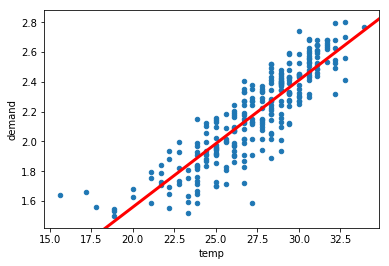

In [19]:
data_summer.plot.scatter("temp", "demand")
plot_model(model)

## Validazione del modello

Per valutare l'accuratezza delle predizioni di un modello ci serve un insieme di esempi di valori noti delle variabili indipendente x e dipendente y: esistono diverse metriche di accuratezza che quantificano l'accuratezza comparando i valori per y previsti dal modello da quelli reali.

Ad esempio, con la funzione `score` di un modello di regressione, passando in input le serie di valori x e y, otteniamo un _coefficiente di determinazione_ ($R^2$) compreso tra 0 e 1 che indica quanto la variabilità della y sia predetta dal modello. Possiamo misurare tale coefficiente sui dati usati per addestrare il modello.

In [20]:
model.score(data_summer[["temp"]], data_summer["demand"])

0.7674218758655923

Tuttavia, per valutare correttamente l'abilità del modello nel generalizzare i dati osservati, abbiamo bisogno di testarlo su un insieme di dati separato.

Per questo, invece di utilizzare l'intero insieme di dati disponibili sui mesi estivi, dividiamo tale insieme in un _training set_ per l'addestramento del modello e in un _validation set_ per la valutazione della sua accuratezza.

scikit-learn fornisce una funzione `train_test_split` per dividere casualmente i dati nei due set secondo una proporzione data.
- L'opzione `test_size=0.3` indica che il 30% dei dati sarà assegnato al validation set, il training set conterrà il restante 70%.
- L'opzione `random_state=42` serve a "fissare" la casualità della divisione: rieseguendo la stessa istruzione con lo stesso `random_state` si otterrà essattamente la stessa divisione dei dati.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(data_summer[["temp"]], data_summer["demand"], test_size=0.3, random_state=42)

In questo modo i valori di `temp` vengono ripartiti casualmente tra `X_train` (training set) e `X_val` (validation set); `y_train` e `y_val` contengono invece i corrispondenti valori di `demand`.

A questo punto creiamo un nuovo modello di regressione lineare.

In [22]:
model = LinearRegression()

Stavolta però addestriamo il modello solamente sui dati del training set, passando come prima la serie di valori della variabile indipendente (X, temperature) e quelli della variabile dipendente (y, consumi).

In [23]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Ora, oltre ad ottenere una valutazione del modello basata sul training set...

In [24]:
model.score(X_train, y_train)

0.7689433269368844

...possiamo ottenerne una più significativa basata sul validation set, contenente dati non visti prima dal modello.

In [25]:
model.score(X_val, y_val)

0.7508669565801298

Il coefficiente calcolato sul validation set è vicino a quello calcolato sul training set: possiamo dedurre che il modello abbia efficacemente generalizzato gli esempi visti nel training set.

## Altri modelli di regressione

Il modello generato sopra prevede abbastanza efficacemente i consumi nei mesi estivi. Ma se volessimo un modello più generale da utilizzare per tutto l'anno?

Rieseguiamo come prima la divisione dei dati in training e validation set, ma questa volta consideriamo la tabella `data` contenente l'intero insieme di dati, non solamente quelli sui mesi estivi.

In [26]:
X_train, X_val, y_train, y_val = \
    train_test_split(data[["temp"]], data["demand"], test_size=0.3, random_state=42)

Testiamo l'accuratezza di un modello di regressione lineare su questi dati.

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.16809034828105496

Il coefficiente questa volta è molto basso, segno che il modello è scarsamente accurato. La causa si può vedere visualizzando il modello nel grafico a dispersione dei dati.

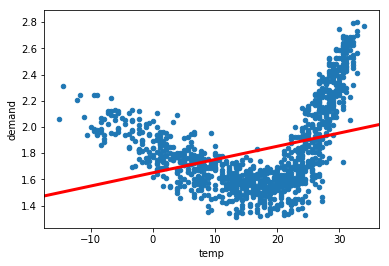

In [28]:
data.plot.scatter("temp", "demand")
plot_model(model)

Un modello di regressione lineare non può essere efficace, in quanto nei dati completi non c'è una correlazione lineare: il consumo di elettricità è alto nei giorni più caldi per via dell'aria condizionata, ma si alza anche nei giorni più freddi per il riscaldamento.

Esistono però molti altri tipi di modelli di regressione, che riescono a catturare dipendenze più complesse tra le variabili. Ad esempio la regressione _kernel ridge_ rispetto alla lineare utilizza delle funzioni _kernel_ che trasformano lo spazio dei dati in modo non lineare e usa la _regolarizzazione_ per rendere meno probabile che il modello "impari a memoria" i dati piuttosto che generalizzarli (fenomeno noto in gergo come _overfitting_).

Creiamo quindi un modello di questo tipo specificandone alcuni parametri, in questo caso il tipo di funzione kernel e l'intensità della regolarizzazione.

In [29]:
from sklearn.kernel_ridge import KernelRidge
model = KernelRidge(kernel="poly", degree=2, alpha=0.1)

Al di la della sua definizione, possiamo interagire con questo modello esattamente come con quelli di regressione lineare, per cui lo addestriamo sul training set con la funzione `fit`...

In [30]:
model.fit(X_train, y_train)

KernelRidge(alpha=0.1, coef0=1, degree=2, gamma=None, kernel='poly',
      kernel_params=None)

...e ne eseguiamo la valutazione sul validation set con la funzione `score`.

In [31]:
model.score(X_val, y_val)

0.726290366053713

Questo modello è molto più accurato, in quanto l'uso di una funzione non lineare riesce a catturare meglio l'andamento dei dati, come si vede sovrapponendo il modello al grafico a dispersione.

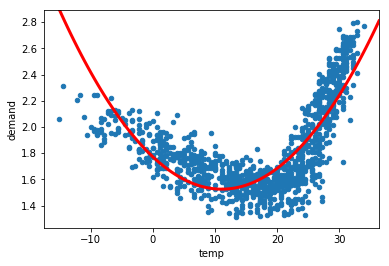

In [32]:
data.plot.scatter("temp", "demand")
plot_model(model)

In pratica al posto della retta abbiamo una parabola, avendo usato una funzione kernel di 2° grado. Se vogliamo testare una funzione kernel di grado maggiore, è sufficiente creare un nuovo modello cambiando il relativo parametro.

In [33]:
model = KernelRidge(kernel="poly", degree=3, alpha=0.1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8221464909721348

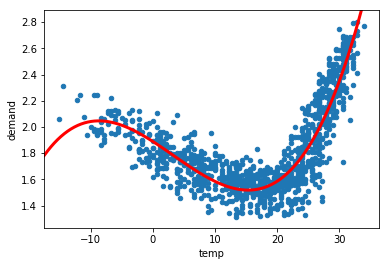

In [34]:
data.plot.scatter("temp", "demand")
plot_model(model)

La curva di 3° grado approssima i dati ancora meglio di quella precedente.

In genere, per arrivare ad avere un modello quanto più accurato possibile, si seleziona una lista di algoritmi da testare (regressione lineare, kernel ridge, ecc.), si eseguono molti test applicando diversi parametri e si seleziona il modello su cui la validazione ha dato il risultato migliore. scikit-learn integra funzionalità (_grid search_) per testare in blocco diverse combinazioni di parametri dati gli intervalli in cui possono variare.

## Esempio 2: stima dei prezzi delle case

Lavoriamo ora sul problema della stima dei prezzi da assegnare alle case in base alle loro caratteristiche.

Il dataset _Boston Housing Data_, usato in ricerca e disponibile sul Web, contiene informazioni sui quartieri residenziali di Boston. Anche se si riferisce a quartieri interi, le caratteristiche riportate sono simili a quelle che si potrebbero individuare per singole case.

I dati possono essere reperiti al seguente URL:

In [35]:
housing_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"

Usiamo anche quì `read_csv` per caricare i dati, impostando alcune opzioni per leggere correttamente questo file specifico (colonne separate da uno o più spazi, niente riga d'intestazione con i nomi delle colonne).

In [36]:
data = pd.read_csv(housing_url, sep="\s+", header=None)

Il numero di righe e colonne è...

In [37]:
data.shape

(506, 14)

Dato che questo file non ha i nomi delle colonne, li assegniamo manualmente secondo le indicazioni date quì: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

In [38]:
data.columns = "CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV".split()

Vediamo alcune righe della tabella completa con i nomi delle colonne

In [39]:
data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Il significato di ciascuna colonna, riportato dalle indicazioni sopra, è:
- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari

Quì l'obiettivo dell'analisi di regressione è estrarre un modello che stimi il valore dell'abitazione (MEDV) avendo note le altre variabili. Estraiamo quindi la serie dei valori da predire della variabile dipendente che chiamiamo y...

In [40]:
y = data["MEDV"]

...e le serie di valori delle altre variabili. Con l'istruzione seguente selezioniamo tutte le variabili tranne MEDV.

In [41]:
X = data.drop(columns=["MEDV"])

Come sopra usiamo la funzione `train_test_split` per dividere i dati tra training e validation set.

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

Verifichiamo l'accuratezza di un modello di regressione lineare.

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7112260057484914

In questo caso con la semplice regressione lineare si ottiene un modello discretamente accurato.

Un modello di regressione lineare ricava il valore della variabile dipendente in pratica come una somma pesata dei valori di quelle indipendenti. Può essere interessante vedere i pesi assegnati alle variabili per capire quanto ciascuna sia importante nella stima del prezzo.

I pesi sono memorizzati in un vettore `coef_` nel modello: l'istruzione seguente li visualizza associando a ciascuno il nome della variabile corrispondente.

In [44]:
pd.Series(model.coef_, index=X.columns)

CRIM       -0.133470
ZN          0.035809
INDUS       0.049523
CHAS        3.119835
NOX       -15.417061
RM          4.057199
AGE        -0.010821
DIS        -1.385998
RAD         0.242727
TAX        -0.008702
PTRATIO    -0.910685
B           0.011794
LSTAT      -0.547113
dtype: float64

Da questi valori si capisce ad esempio che il modello stima che una casa vicina al fiume Charles (variabile CHAS=1) valga generalmente circa 3.100 dollari in più, mentre per ogni stanza (variabile RM) il valore a parità di metratura e altri fattori cresce di circa 4.000 dollari. Si tenga presente che la forte differenza tra i valori è data per lo più dalle differenze di scala delle diverse variabili.

Come sopra, oltre alla regressione lineare, testiamo anche la kernel ridge e vediamo se si ottiene un modello più accurato.

In [45]:
model = KernelRidge(kernel="poly", degree=2, alpha=0.1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7506893743389089

In questo caso il risultato della kernel ridge è superiore solo di poco rispetto alla regressione lineare, ma potrebbe variare cambiando i parametri.

## Esercizi proposti

- Rieseguire la cella sopra con valori diversi dei parametri `degree` (grado della funzione kernel) e/o `alpha` (intensità di regolarizzazione), verificare se si riesce ad ottenere un modello più accurato
- Scegliere dal set di dati una delle variabili indipendenti (es. TAX), visualizzarne in un grafico a dispersione la correlazione col valore della casa (MEDV) e verificare l'accuratezza di un modello di regressione addestrato solo su quella variabile.